In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import obspy
import librosa
import resampy

import os.path
import sys
sys.path.append('./sonification_codes/classes/')
import CMMR_class as dbap


In [77]:
# THIS VERSION DOES ONE STATION, MULTIPLE SPEAKERS, USING DBAP ! (another notebook for data from multiple stations)
# post October 2019 on the CMC 313 computer: 



# DirCatalog = '/home/ben/githole/earthquack/projects/catalog_movies/quakes/kilauea_2018_zoom/'
# DirCatalog = '/home/ben/data/Kilauea/'
# FileCatalog = 'EQ_Eruption_Catalog_4_1_2018_8_30_2018_HVO_validdata.csv'

FOV='big'

if FOV=='big':
    station_name = 'STCD'
    catname_pkl = './catalogs/cat_STDC_bigview.pkl'  
    DataDir = '/home/ben/data/Kilauea/waveforms_' + station_name + '/'
    minMag = 2.5
    maxMag = 6.5 
    new_event_dur = 0.15#0.3#0.3
    movie_duration = 180#120.0 # in seconds
    soundrootname = 'kil2018_'+FOV+'_dur'+str(movie_duration)+'edur'+str(new_event_dur)+'m'+str(minMag)+'_M'+str(maxMag)
    soundrootname.replace('.','p')
if FOV=='zoom':
    station_name = 'PUHI'
    catname_pkl = './catalogs/cat_PUHI_zoomview.pkl'  
    DataDir = '/home/ben/data/Kilauea/waveforms_' + station_name + '/'
    minMag = 5 # 2.3
    new_event_dur = 0.5 #0.3
    movie_duration = 60.0 # 120 in seconds
    soundrootname = 'kil2018_'+FOV+'_dur'+str(movie_duration)+'edur'+str(new_event_dur)+'m'+str(minMag)+'_M'+str(maxMag)
    soundrootname.replace('.','p')
if FOV=='zoomOneCycle':
    station_name = 'PUHI'
    catname_pkl = './catalogs/cat_PUHI_zoomOnecycle_v2.pkl'  
    DataDir = '/home/ben/data/Kilauea/waveforms_' + station_name + '/'
    minMag = 4.5#1.5
    new_event_dur = 0.8# 0.15
    movie_duration = 180.0 # in seconds
    soundrootname = 'kil2018_'+FOV+'_dur'+str(movie_duration)+'edur'+str(new_event_dur)+'m'+str(minMag)+'_M'+str(maxMag)
    soundrootname.replace('.','p')
    
tab = pd.read_pickle(catname_pkl)
print(tab.columns)
print('The catalog is a dataframe of size ' + str(tab.shape))
#print('I will assume (correct me if I\'m wrong) that the fields are:\n\t year\n\t month\n\t day\n\t hour\n\t minute\n\t seconds\n\t latitude\n\t longitude\n\t depth\n\t magnitude\n\t id')
print('There are ' + str(len(tab['time'])) + ' events')
print(tab.time.iloc[2])

Index(['time', 'lat', 'lon', 'depth', 'mag', 'dist from Halemaumau (degrees)',
       'id', 'type', 'horizontalError', 'depthError', 'magError'],
      dtype='object')
The catalog is a dataframe of size (41319, 11)
There are 41319 events
2018-04-01T08:09:00.750Z


2018-04-01T06:59:02.810Z 2018-08-30T15:26:45.430Z


Text(0, 0.5, 'start time (data time, s)')

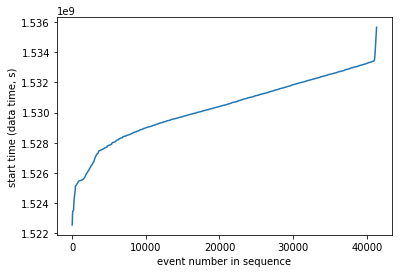

In [78]:
### THIS SHOULD HAVE ALREADY BEEN DONE

# Get the start time of each event as a timestamp
starttimes = np.zeros(len(tab['time']))
for k in range(0,len(tab['time'])-1):
    starttimes[k] = obspy.UTCDateTime(tab['time'][k]).timestamp
    
tab['starttimes'] = pd.Series(starttimes) # and put it in the dataframe
tab = tab[tab.starttimes>0.0]

print(tab['time'].iloc[0],tab['time'].iloc[-1])
plt.plot(tab.starttimes)
plt.xlabel('event number in sequence')
plt.ylabel('start time (data time, s)')

In [79]:
# # Sort the dataframe according to time stamps
# tab = tab.sort_values(by=['starttimes'])

# # And reset indices
# tab = tab.reset_index()
# print(tab.columns)
# NbEvents = len(tab['time'])
# print('There are ' + str(NbEvents) + ' events left')

# plt.plot(tab.starttimes)
# plt.xlabel('event number in sequence')
# plt.ylabel('start time (movie time, s)')

In [80]:
#tab = tab.drop(columns=['level_0'])
# Get rid of events of lower magnitude
 
tab.mag = pd.to_numeric(tab.mag, errors='coerce')
tab = tab.drop(tab[tab['mag'] < minMag].index)
tab = tab.drop(tab[tab['mag'] > maxMag].index)
N_evts = len(tab['mag'])
print('There remain ' + str(N_evts) + ' events')
maxMag = np.amax(tab['mag'])
print('The biggest is ' + str(maxMag))

# And reset indices

tab = tab.reset_index()

#print(tab)

print(tab.index[tab.id=='hv70352901'])
print(tab.index[tab.id=='hv70359161'])

There remain 15865 events
The biggest is 5.4
Int64Index([], dtype='int64')
Int64Index([8511], dtype='int64')


5.4
2.5
us2000dyks
hv70564787
15864


Text(0, 0.5, 'magnitude')

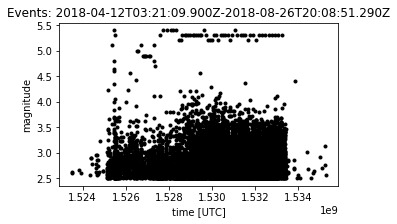

In [81]:
fig = plt.figure(figsize = (5,3))
titletext = 'Events: ' + str(tab['time'].iloc[0])+ '-' + str(tab['time'].iloc[-1])

# for zoomOneCycle
# istart = 15463 
# iend = 16052
# # interval = 590 not used anymore
istart = 0 
iend = len(tab)-1



maxMag = np.amax(tab['mag'][istart:iend])
minMag = np.amin(tab['mag'][istart:iend])
print(maxMag)
print(minMag)
print(tab.id.iloc[istart])
print(tab.id.iloc[iend])
print(len(tab['starttimes'][istart:iend]))
#plt.plot(time_years,tab['mag'],'.k')
plt.plot(tab['starttimes'][istart:iend],tab['mag'][istart:iend],'.k')
plt.title(titletext)
plt.xlabel('time [UTC]')
plt.ylabel('magnitude')

In [82]:
# fig_path = './'
# figname_map = fig_path + 'catalog_plot' +'.png'
# fig.savefig(figname_map, pad_inches=0.0, bbox_inches='tight', dpi=300)

# Movie parameters

In [83]:
### THESE SHOULD BE IN INFOPICKLES

#movie_duration = 120.0 #*interval/len(tab.id) # in seconds
print(movie_duration)
movie_dt = 1/29.97 #0.1 # in seconds
movie_t = np.arange(0,movie_duration,movie_dt) 
# what is this movie dt ?  10 frames per sec? 

180


In [84]:
# rescale data start times to movie time
max_starttime = np.amax(tab['starttimes'][istart:iend]-tab['starttimes'][istart])
print(max_starttime)
movie_starttimes = (tab['starttimes'][istart:iend]-tab['starttimes'][istart])*movie_duration/max_starttime
#print(movie_starttimes)

11764169.079999924


# Sound parameters

In [85]:
# NUMBER OF SPEAKERS! 
N_speakers = 2
!pwd
pklname = 'spkrs' + str(N_speakers) + '_' + FOV + '.pkl'
spkrs = pd.read_pickle(pklname)
print(spkrs.columns)

OldStereoWay = 0

/home/ben/Dropbox/x03_datamovies/Kilauea_2018
Index(['name', 'lon', 'lat'], dtype='object')


In [86]:
real_event_dur = 70.0 # seconds
#new_event_dur = 0.3 #0.4 # seconds  0.1 is too fast
#new_event_dur = 0.3 #/0.35 #0.4 # seconds  0.1 is too fast
# MOVED this parameter definition up top into the zoom or full view settings. 

SpeedFactor = real_event_dur/new_event_dur
print(SpeedFactor)

data_sr = 100.
audio_sr = 44100


466.6666666666667


In [87]:
#data = np.loadtxt(DataDir + 'hv70068046.txt',delimiter=',', skiprows=1)
#data[:,1]
print(tab.columns)

Index(['index', 'time', 'lat', 'lon', 'depth', 'mag',
       'dist from Halemaumau (degrees)', 'id', 'type', 'horizontalError',
       'depthError', 'magError', 'starttimes'],
      dtype='object')


0 of 15864
1000 of 15864
2000 of 15864
3000 of 15864
4000 of 15864
5000 of 15864
6000 of 15864
7000 of 15864
8000 of 15864
9000 of 15864
10000 of 15864
11000 of 15864
12000 of 15864
13000 of 15864
14000 of 15864
15000 of 15864
0 files not found


Text(0.5, 1.0, 'Speedfactor = 466.6666666666667, sr = 100.0Hz')

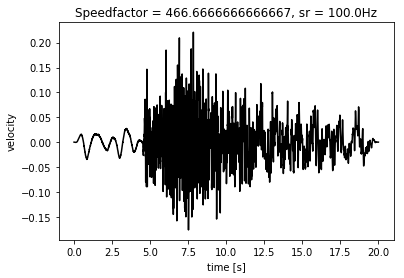

In [88]:
filenotfoundlist = []

#istart = 0
#interval = len(tab)-2

for isp in range(N_speakers): 
    exec('track_' + str(isp+1) + '= np.zeros(int(movie_duration*audio_sr))')


for k in range(istart,iend): #(0,N_evts-1): #range(100,101): #
#for k in range(0,50):
    if k%1000==0:
        print(str(k)+' of '+str(iend-istart))
    current_id = tab['id'][k]
    #print(current_id)

    # Build the name of the file to load
#     currentjulday = obspy.UTCDateTime(tab['starttimes'][k]).julday
#     current_filename = makefilenamestring(currentjulday)
    current_filename = current_id+'.txt'
    
    if os.path.exists(DataDir + current_filename): # Test if file exists
        #print(current_filename)
        
        # Test if the data is not going beyond the limits we set for the sound track
        # FIX this so that there is extra time at the end ! 
        if movie_starttimes[k]+real_event_dur/SpeedFactor < movie_duration: 
            # Load data
            data = np.loadtxt(DataDir + current_filename,delimiter=',', skiprows=1)
            data = data[:,1]

            if len(data) > .75*(real_event_dur*data_sr): # Process only if the data is long enough (entire data should be 20 s @ 500 Hz)
                data = data - np.mean(data) # de-mean (already did this in obspy getting the data)
                
                # NORMALIZE
                data = data/np.amax(np.absolute(data)) # normalize
                #print(data[0:5])
                #data = data*(tab['mag'][k]/(2*maxMag)) # TEST -- linear mapping of magnitude to amplitude 
                
                distances = np.zeros(N_speakers)
                sum__ = 0
                for isp in range(N_speakers):
                    distances[isp] = dbap.EuclDistance([tab.lon[k],tab.lat[k]],[spkrs.lon[isp],spkrs.lat[isp]])
                    #print(distances)
                    sum__ = sum__+1/(distances[isp]**2)
                    
                #print(sum__)
                #print(distances) 
                C = np.sqrt(1/sum__) # normalization constant
                #print(C)
                #print(max(data))
                # SCALE DATA BY MAGNITUDE (linear mapping)
                data = data*np.interp(tab['mag'][k],[minMag,maxMag],[0.0001,1]) # used to be [0.001,1.0] #used to be [0.001,1.0]
                #print(max(data))
                # ADD TO THE SOUNDTRACK! 
                
                i_start = int(movie_starttimes[k]*audio_sr)               
                #print(distances)
                for isp in range(N_speakers):
                    # DBAP scaling ! 
                    #print(max(data))
                    data_db = data*C/distances[isp]
                    
                    # RESAMPLE
                    data_resampled = resampy.resample(data_db, data_sr*SpeedFactor, audio_sr) # resample to audio rate
                    i_end = i_start+len(data_resampled)
                    exec('track_' + str(isp+1) + '[i_start:i_end] = track_' + str(isp+1) + '[i_start:i_end] + data_resampled')
                    # which reads "track_0[start_index:end_index] = track_0[start_index:end_index] + click*C/distance[0]"


        else:
            balbal = 2
            #print('\t Not processing file ' + current_filename + ' because it would exceed the length of the soundtrack')
    else:
        #print('File ' + current_filename + ' does not exist...')
        filenotfoundlist.append(current_filename)
        
        
print(str(len(filenotfoundlist))+' files not found')

fig = plt.figure(figsize = (6,4))
sigtime = np.linspace(0,20.0,len(data))  
plt.plot(sigtime,data, 'k')
titletext = 'Speedfactor = ' + str(SpeedFactor)+ ', sr = ' + str(data_sr) + 'Hz'
plt.xlabel('time [s]')
plt.ylabel('velocity')
plt.title(titletext)

#ch_l[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled_l))] = \
                  #  ch_l[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled_l))] + data_resampled_l

[1.3130301790383732, 0.9728850138397986]
1.3130301790383732
filenameforexport = "kil2018_full_dur180_edur0p15_M2p5_6p5track_1of2.wav"
filenameforexport = "kil2018_full_dur180_edur0p15_M2p5_6p5track_2of2.wav"


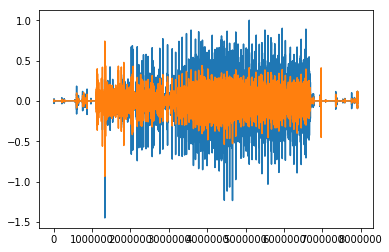

In [89]:
max_all = []
for isp in range(N_speakers):
    exec('max_all.append(max(track_'+str(isp+1)+'))')
print(max_all)

DirOut = './'

maxmax = max(max_all)
print(maxmax)
for isp in range(N_speakers):
    cmd = 'filenameforexport = "' + soundrootname + 'track_' + str(isp+1) + 'of' + str(N_speakers) + '.wav"'
    print(cmd)
    exec(cmd)
    exec('track_'+str(isp+1)+'= track_'+str(isp+1)+'/maxmax')
    exec('librosa.output.write_wav(DirOut + filenameforexport, track_'+str(isp+1)+', audio_sr, norm=False)')
    exec('plt.plot(track_'+str(isp+1)+')')


In [ ]:
print(tab.columns)
print(tab.time.iloc[-1],tab.id.iloc[-1])

In [ ]:
29.9700/30.0000


In [ ]:
#DirOut = DirCatalog
DirOut = './'
for isp in range(N_speakers):
    filenameforexport = 'Kilauea2018_track_'+str(isp) +'.wav'
    SoundTrack = SoundTrack/np.amax(SoundTrack)# normalize
    librosa.output.write_wav(DirOut + filenameforexport, SoundTrack, audio_sr, norm=True)

In [ ]:
if OldStereoWay == 1:
    SoundTrack = np.zeros((2,int(movie_duration*audio_sr)))
    ch_l = np.zeros(int(movie_duration*audio_sr))
    ch_r = np.zeros(int(movie_duration*audio_sr))
    print(len(ch_l))
    # weighting between L and R channels
    tab.lon = pd.to_numeric(tab.lon, errors='coerce')

    stereo_r = (tab.lon-min(tab.lon))/(max(tab.lon)-min(tab.lon))
    stereo_l = 1-stereo_r
#    plt.plot(stereo_r[0:10])
#    plt.plot(stereo_l[0:10])


In [ ]:
filenotfoundlist = []

# ANY SCALING OF THE AMPLITUDE BY MAGNITUDE 
# or are all sounds normalized to same value ? 


for k in range(istart,istart+interval): #(0,N_evts-1): #range(100,101): #
#for k in range(0,50):
    if k%1000==0:
        print(str(k)+' of '+str(interval))
    current_id = tab['id'][k]
    #print(current_id)

    # Build the name of the file to load
#     currentjulday = obspy.UTCDateTime(tab['starttimes'][k]).julday
#     current_filename = makefilenamestring(currentjulday)
    current_filename = current_id+'.txt'
    
    if os.path.exists(DataDir + current_filename): # Test if file exists
        #print(current_filename)
        
        # Test if the data is not going beyond the limits we set for the sound track
        # FIX this so that there is extra time at the end ! 
        if movie_starttimes[k]+real_event_dur/SpeedFactor < movie_duration: 
            # Load data
            data = np.loadtxt(DataDir + current_filename,delimiter=',', skiprows=1)
            data = data[:,1]

            if len(data) > .75*(real_event_dur*data_sr): # Process only if the data is long enough (entire data should be 20 s @ 500 Hz)
                #data = data - np.mean(data) # de-mean (already did this in obspy getting the data)
                
                # NORMALIZE
                data = data/np.amax(np.absolute(data)) # normalize
                #data = data*(tab['mag'][k]/(2*maxMag)) # TEST -- linear mapping of magnitude to amplitude 
                
                # SCALE amplitude BY MAGNITUDE 
                data = data*np.interp(tab['mag'][k],[minMag,maxMag],[0.001,1])
                
                # WEIGHT AMPLITUDE BY DISTANCE ! DBAP  
                data_l = data*stereo_l[k]
                data_r = data*stereo_r[k]
                

                # RESAMPLE
                data_resampled_l = resampy.resample(data_l, data_sr*SpeedFactor, audio_sr) # resample to audio rate
                data_resampled_r = resampy.resample(data_r, data_sr*SpeedFactor, audio_sr) # resample to audio rate
                #t_resampled = np.arange(0,len(data_resampled)/audio_sr,1/audio_sr)
                #plt.plot(t_resampled,data_resampled)

                # Fill the appropriate part of the sound track with the newly audified data
#                 SoundTrack[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled))] = \
#                     SoundTrack[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled))] + data_resampled

                ch_l[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled_l))] = \
                    ch_l[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled_l))] + data_resampled_l
    
                ch_r[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled_r))] = \
                    ch_r[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled_r))] + data_resampled_r
        else:
            balbal = 2
            #print('\t Not processing file ' + current_filename + ' because it would exceed the length of the soundtrack')
    else:
        #print('File ' + current_filename + ' does not exist...')
        filenotfoundlist.append(current_filename)
        
        
print(str(len(filenotfoundlist))+' files not found')

fig = plt.figure(figsize = (6,4))
sigtime = np.linspace(0,20.0,len(data))  
plt.plot(sigtime,data, 'k')
titletext = 'Speedfactor = ' + str(SpeedFactor)+ ', sr = ' + str(data_sr) + 'Hz'
plt.xlabel('time [s]')
plt.ylabel('velocity')
plt.title(titletext)
                #t_data = np.arange(0,len(data)/data_sr,1/data_sr)
                #plt.plot(t_data,data)
                #plt.xlabel('t (s)')

In [ ]:
plt.plot(ch_l)
plt.savefig('ch_l_0.001:1_maxmag5.3.png')

In [ ]:
SoundTrack[0,:] = ch_l
SoundTrack[1,:] = ch_r

# And export the sound file

In [ ]:
#DirOut = DirCatalog
DirOut = './'
filenameforexport = 'Kilauea2018_full_'+station_name +'.wav'
SoundTrack = SoundTrack/np.amax(SoundTrack)# normalize
librosa.output.write_wav(DirOut + filenameforexport, SoundTrack, audio_sr, norm=True)

In [ ]:


# nfiles = len(tab.valid)
# print(nfiles)
# print(type(tab.valid.iloc[12]))

# count = 0
# for i in range(1,nfiles):
#     validity = int(tab.valid.iloc[i])
#     if validity==1:
#         count += 1

# print(count)




In [ ]:
# npts = 7000
# ntot = len(datamat)
# nfiles = int(np.floor(ntot/(npts-1)))

# print(nfiles)

In [ ]:
# old stuff

#tab = pd.read_csv(DirCatalog + FileCatalog, header=None, delimiter=',', \
#                 names = ['years','months','days','hours','minutes','seconds','lat','lon','dep','mag','degrees','id'])
#names_vec = ['time','lat','lon','dep','mag','degrees','id', 'type', 'error1', 'error2', 'error3','valid']
#tab = pd.read_csv(DirCatalog + FileCatalog, header=None, delimiter=',', names=names_vec)


# DirCatalog = 'data/'
#DirData = '/home/ben/data/Kilauea/eqcatalogdata/'  # for waveforms, add /AL4Catalog = '/Volumes/linux/ML_data/NWGeysers/GeysersNW_data/'
#DataFile = 'top100k.txt'
#DataFile = 'Kilauea_eq_OBL.txt'

#datamat = np.loadtxt(DirData+DataFile, delimiter=',', skiprows=1)
#print(datamat.shape)

# tex = obspy.UTCDateTime(tab.time[0])
# print(tex)
# print(tex.timestamp)
# #tab.time[0]

In [ ]:
# nfiles_cat = len(tab.id)
# print(nfiles_cat)
# count = 0

# for i in range(1,nfiles_cat-1):
#     validity = int(tab.valid.iloc[i])
#     if validity==1:        
#         start = count*npts
#         fin = start+npts
#         #print(start,fin)
#         time = datamat[start:fin,0]
#         #print(time[0])
#         trace = datamat[start:fin,1] 
#         name = tab.id[i] + '.txt'
#         np.savetxt(DirData+'waveforms_test/'+name, trace)
        
#         count += 1
        
# print(count)